In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

# os.environ["JAX_PLATFORM_NAME"] = "CPU"
# # ENSURE JAX DOESNT PREALLOCATE
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(False)

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.data import make_mini_batcher
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from model import add_model_args, get_model
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

2022-06-01 17:47:26.740554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Argumentsget_data_args

In [3]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_args(parser)
parser = add_loss_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"

args.smoke_test = False
args.wandb_mode = "online"
args.wandb_resume = True
# ige/nerf4ssh/kx2nr6qb
args.id = "kx2nr6qb" # "mikf2n1v" # "2uuq7tks" "generous-snowflake-46"
# args.entity = "ige"
args.batch_size = 2048
args.n_epochs = 10
args.batch_size = 4096

### Logger


In [4]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (ige). Use `wandb login --relogin` to force relogin
2022-06-01 17:47:35.427081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Load Data

In [5]:
%%time

# load data
data = load_data(args)

# preprocess data
data = preprocess_data(data, args)

# feature transformation
data, scaler = feature_transform(data, args)

# split data
xtrain, ytrain, xvalid, yvalid = split_data(data, args)

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]
args.n_valid = xvalid.shape[0]

wandb.config.update(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
        "n_valid": args.n_valid,
    }
)

100%|██████████| 6/6 [00:00<00:00, 16.67it/s]


CPU times: user 2.48 s, sys: 246 ms, total: 2.73 s
Wall time: 2.98 s


In [6]:
data[["longitude", "latitude", "time_transform"]].head()

,longitude,latitude,time_transform
0,0.633663,-0.998266,-1.0
1,0.632683,-0.994338,-1.0
2,0.631703,-0.990410,-1.0
3,0.630723,-0.986482,-1.0
4,0.629742,-0.982554,-1.0


### Model

In [7]:
%%time


# model
model = get_model(args)

# optimizer
optimizer = get_optimizer(args)

# loss
make_step, val_step = get_loss_fn(args)

# init model
opt_state = optimizer.init(model)

CPU times: user 1.29 s, sys: 237 ms, total: 1.52 s
Wall time: 3.34 s


In [8]:
n_steps_per_epoch = args.n_train / args.batch_size
steps = int(n_steps_per_epoch * args.n_epochs) if not args.smoke_test else 500


wandb.config.update(
    {
        "steps": steps,
        "n_steps_per_epoch": n_steps_per_epoch,
    }
)

### Training

In [ ]:
train_ds = make_mini_batcher(xtrain, ytrain, args.batch_size, 5, shuffle=True)
valid_ds = make_mini_batcher(xvalid, yvalid, args.batch_size, 5, shuffle=False)


losses = {} 
losses["train"] = []
losses["valid"] = []


with tqdm.trange(steps) as pbar:
    for step in pbar:
        
        ix, iy = next(train_ds)
        loss, grads = make_step(model, jnp.asarray(ix), jnp.asarray(iy))
        
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        
        losses["train"].append(loss)
        wandb.log({"train_loss": loss}, step=step)
        ix, iy = next(valid_ds)
        # validation step
        vloss = val_step(model, jnp.asarray(ix), jnp.asarray(iy))
        losses["valid"].append(vloss)
        
        
        wandb.log({"val_loss": vloss}, step=step)
        
        if step % 10 == 0:
            pbar.set_description(f"Step: {step:_} | Train Loss: {loss:.3e} | Valid Loss: {vloss:.3e}")
            


2022-05-31 16:53:54.580108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Step: 180 | Train Loss: 2.399e-02 | Valid Loss: 1.438e-01:   5%|▍         | 186/3933 [00:28<07:30,  8.33it/s]

### Save models

In [23]:
# objects
path_model = Path(wandb.run.dir).joinpath("model.pickle")
path_scaler = Path(wandb.run.dir).joinpath("scaler.pickle")

# models to save
save_object(model, path_model)
save_object(scaler, path_scaler)

# save with wandb
wandb.save(str(path_model), policy="now")
wandb.save(str(path_scaler), policy="now")

### Load Models (Optional)

In [5]:
# if args.server == "jz":
# get id (from this run or a run you can set)
run_id = wandb.run.id

# initialize api
api = wandb.Api()

# get run
run = api.run(f"{args.entity}/{args.project}/{run_id}")

# download the files
files = [
    "scaler.pickle", 
    "model.pickle"
]

for ifile in files:
    
    run.file(ifile).download(replace=True)

In [6]:
model = load_object("./model.pickle")
scaler = load_object("./scaler.pickle")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### PostProcessing

In [7]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude
count,967980.000000,967980.000000
mean,300.000000,38.100000
std,2.943922,3.001668
min,295.000000,33.000000
25%,297.400000,35.550000
50%,300.000000,38.100000
75%,302.600000,40.650000
max,305.000000,43.200000


In [8]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe(), df_grid.describe()

(          longitude       latitude  time_transform
 count  9.679800e+05  967980.000000   967980.000000
 mean  -2.666668e-07       0.006669       -0.000004
 std    1.962616e-01       0.200112        0.494783
 min   -3.333338e-01      -0.333332       -0.854648
 25%   -1.733337e-01      -0.163331       -0.427326
 50%   -2.666668e-07       0.006669       -0.000004
 75%    1.733332e-01       0.176670        0.427317
 max    3.333333e-01       0.346671        0.854639,
            longitude       latitude
 count  967980.000000  967980.000000
 mean      300.000000      38.100000
 std         2.943922       3.001668
 min       295.000000      33.000000
 25%       297.400000      35.550000
 50%       300.000000      38.100000
 75%       302.600000      40.650000
 max       305.000000      43.200000)

In [9]:
wandb.config.update(
    {
        "n_test": df_pred.shape[0],
    }
)

### Predictions


In [10]:
@jax.jit
def pred_step(model, data):
    return jax.vmap(model)(data)

In [11]:
from ml4ssh._src.model_utils import batch_predict
from functools import partial
import time

In [12]:
df_pred = jnp.asarray(df_pred[df_pred.columns.difference(["time"])].values)

fn = partial(pred_step, model)

t0 = time.time()
df_grid["pred"] = batch_predict(df_pred, fn, args.eval_batch_size)
t1 = time.time() - t0

97it [00:24,  4.00it/s]


In [13]:
# wandb.config.update(
#     {
#         "time_predict_batches": t1,
#     }
# )

In [14]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/miss

In [15]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 365)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 ... 967977 967978 967979
    pred       (latitude, longitude, time) float32 0.02316 0.01256 ... 0.1113
    ssh        (latitude, longitude, time) float64 0.6228 0.6122 ... -0.06499

In [16]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

CPU times: user 760 ms, sys: 40 ms, total: 800 ms
Wall time: 785 ms


In [17]:
rmse_metrics

RMSEStats(rmse_mean=0.3046778244607079, rmse_std=0.09943663095106017, nrmse_mean=0.4846125014914514, nrmse_std=0.35582778394737674)

In [18]:
psd_metrics = get_psd_metrics(ds_oi, args)

### Figures

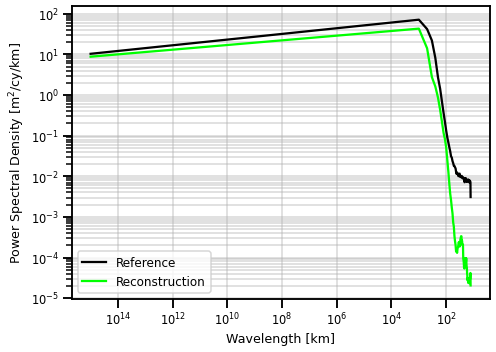

In [19]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

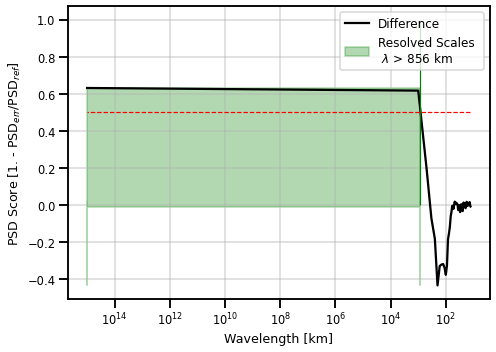

In [20]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

In [23]:
model

SirenNet(
  layers=[
    Siren(
      weight=f32[512,3](numpy),
      bias=f32[512](numpy),
      w0=30.0,
      activation=Sine(w0=30.0)
    ),
    Siren(
      weight=f32[512,512](numpy),
      bias=f32[512](numpy),
      w0=1.0,
      activation=Sine(w0=1.0)
    ),
    Siren(
      weight=f32[512,512](numpy),
      bias=f32[512](numpy),
      w0=1.0,
      activation=Sine(w0=1.0)
    ),
    Siren(
      weight=f32[512,512](numpy),
      bias=f32[512](numpy),
      w0=1.0,
      activation=Sine(w0=1.0)
    ),
    Siren(
      weight=f32[512,512](numpy),
      bias=f32[512](numpy),
      w0=1.0,
      activation=Sine(w0=1.0)
    ),
    Siren(
      weight=f32[512,512](numpy),
      bias=f32[512](numpy),
      w0=1.0,
      activation=Sine(w0=1.0)
    ),
    Siren(
      weight=f32[512,512](numpy),
      bias=f32[512](numpy),
      w0=1.0,
      activation=Sine(w0=1.0)
    ),
    Siren(
      weight=f32[1,512](numpy),
      bias=f32[1](numpy),
      w0=1.0,
      activation=Identity()


### Movies

In [24]:
save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [1]:
# import hvplot.xarray


# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

### Gradients

In [29]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [2]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

### Laplacian

In [31]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [32]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh_lap)